In [26]:
#Read the NxCALS variable into spark dataframe
#featureParameters = ['FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST','FQSTR_013_VOL_QT244.POSST']

#This cell is tagged "parameters"
start_date = "2021-02-25"
#start_time = "01:01:01.001"
end_date = "2021-02-26"
#end_time = "02:02:02.002"
site = "meyrin"

if site not in ["meyrin", "prevessin"]:
    print("The site name can be either meyrin or prevessin. Please modify your input.")

## Water Counter report for the EN-CV group

by Soren Poulsen (EN-CV-CL)


In [27]:
# Connect to the cluster (NXCals)
# reference to NXCALS API - http://nxcals-docs.web.cern.ch/0.1.164/user-guide/library-reference/
# source the nxcals python libs
from cern.nxcals.pyquery.builders import *
from pyspark.sql import DataFrame

from pyspark.sql.functions import *
import ipywidgets as widgets
import pandas as pd
pd.set_option('display.notebook_repr_html', True)

In [28]:
#format dates
selectedDate=datetime.strptime(start_date, '%Y-%m-%d')
#type(selectedDate)
selectedDate = datetime.combine(selectedDate, datetime.min.time())
#print(selectedDate)
ModStartTime = selectedDate
#ModEndTime = selectedDate + timedelta(days = 1)
ModEndTime=datetime.strptime(end_date, '%Y-%m-%d')
ModEndTime=datetime.combine(ModEndTime, datetime.min.time())

#print(ModStartTime)
#print(ModEndTime)

In [29]:
# Build the query and load data into spark dataframe
# Predefined time period is 1 day

if site == "meyrin":
    listCounters = ['FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST']
    # initialise data of lists.
    dataTable = { 'Counter':['FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST'],
            'Description':['short desc', 'short desc', 'short desc'],
            'Building':['241', '242', '243'],
            'Consumption(m3)':[0,0,0],
            'Min(m3)':[0,0,0],
            'Max(m3)':[0,0,0]
           }
    # Creates pandas DataFrame.
    #dfResults = pd.DataFrame(dataTable, index =['FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST'])
    dfResults = pd.DataFrame(dataTable)
elif site == "prevessin":
    listCounters = ['FQSTR_013_VOL_QT243.POSST']
else:
    print("The site name can be either meyrin or prevessin. Please modify your input.")
    
#print(listCounters)
#dfResults

In [30]:
dfList = []
for i in range(len(listCounters)):
    dfList.append(KeyValuesQuery.builder(spark).system("WINCCOA").startTime(ModStartTime).endTime(ModEndTime).entity().keyValueLike("variable_name", listCounters[i]).buildDataset())
    
#print(dfList)
#type(dfList[0])
#dfList[0].printSchema()
#dfList[0].show(5,False)


In [31]:
#sorting by date
for i in range(len(dfList)):
    dfList[i] = dfList[i].select("variable_name", "value", "nxcals_entity_id", from_unixtime(dfList[i].timestamp/1000000000,format='yyyy-MM-dd HH:mm:ss').alias('date')).orderBy("date")
    #dfList[i].show(5,False)


In [32]:
#Data visualization
#creating list of pandas elements
pandas_dfList = []

for i in range(len(dfList)):
    pandas_dfList.append(dfList[i].select('variable_name', 'value', 'date').orderBy("date").toPandas()) 
    pandas_dfList[i]["date"] = pd.to_datetime(pandas_dfList[i]["date"])


In [33]:
#%%capture out

minList = [] #list containing the minimum value of every counter
maxList = [] #list containing the maximum value of every counter
totalList = [] #list containing the total value of every counter (subtraction max - min)

#print(pandas_dfList[i].variable_name)

for i in range(len(pandas_dfList)):
    minList.append(pandas_dfList[i]['value'].min() / 1000)
    maxList.append(pandas_dfList[i]['value'].max() / 1000)
    #taking only 3 decimals
    tempTotal="{:.3f}".format((maxList[i] - minList[i]))
    tempTotal=float(tempTotal)
    totalList.append(tempTotal)
    #print(pandas_dfList[i].variable_name)
    
    #print(listCounters[i])
    #print('value at '+str(ModStartTime)+': ' +str(minList[i])+' m3')
    #print('value at '+str(ModEndTime)+': ' +str(maxList[i])+' m3')
    #print('total:'+str(totalList[i])+' m3')
    #print(' ')
    
    #dfResults.loc[listCounters[i]]['Consumption(m3)']=totalList[i]
    #dfResults.loc[['FQSTR_013_VOL_QT241.POSST'], ['Consumption(m3)']]=totalList[i]
    
#result=dfResults.loc['FQSTR_013_VOL_QT241.POSST']
#result

print('Period: '+str(ModStartTime)+' to '+str(ModEndTime))

for i in range(len(totalList)):
    dfResults.loc[[i],['Consumption(m3)']]=totalList[i]
    dfResults.loc[[i],['Min(m3)']]=minList[i]
    dfResults.loc[[i],['Max(m3)']]=maxList[i]


def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

(pandas_df_to_markdown_table(dfResults))

Period: 2021-02-25 00:00:00 to 2021-02-26 00:00:00


Counter|Description|Building|Consumption(m3)|Min(m3)|Max(m3)
---|---|---|---|---|---
FQSTR_013_VOL_QT241.POSST|short desc|241|28.1|2455.7|2483.8
FQSTR_013_VOL_QT242.POSST|short desc|242|0.442|43.647|44.089
FQSTR_013_VOL_QT243.POSST|short desc|243|1.1|3.1|4.2


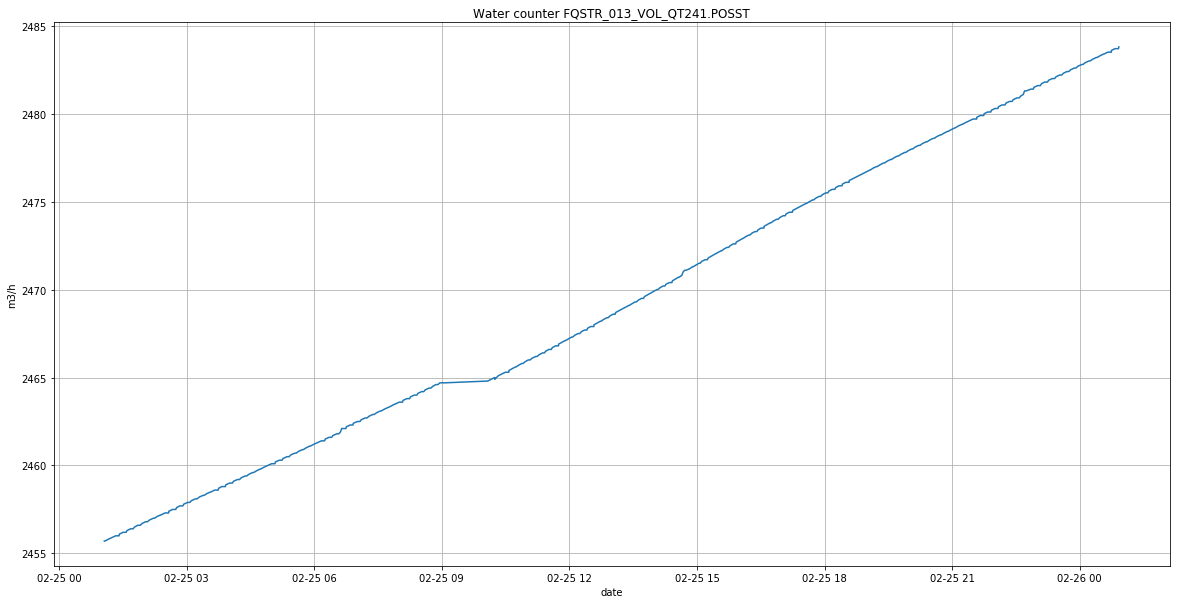

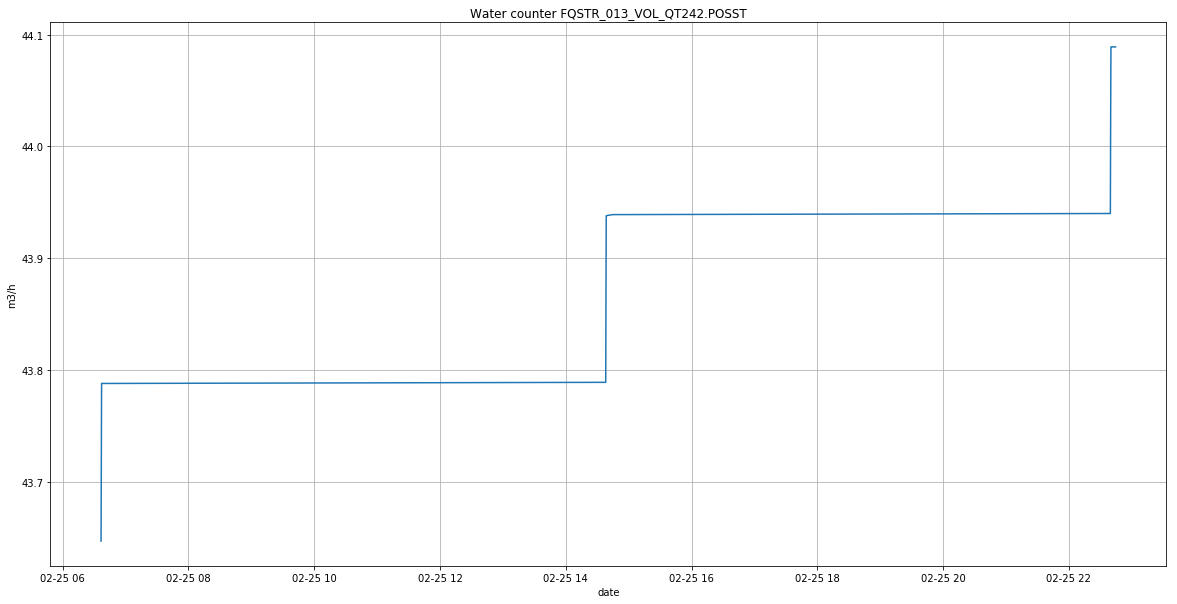

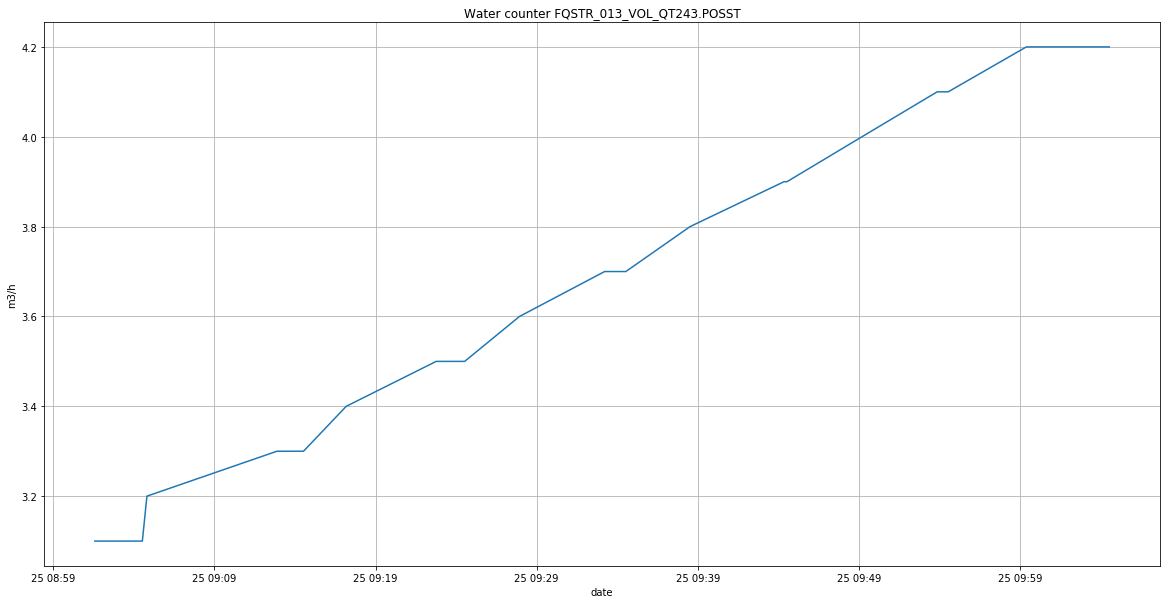

In [38]:
import matplotlib.pyplot as plt
#%matplotlib notebook

figuresList = []

for i in range(len(pandas_dfList)):
    fig = plt.figure(figsize=(20, 10))
    #plt.plot([0,1], [0,1], 'k--', color='orange')
    plt.plot(pandas_dfList[i].date, pandas_dfList[i].value/1000)

    plt.xlabel('date')
    plt.ylabel('m3/h')
    plt.title('Water counter '+ listCounters[i])
    #plt.legend(loc='lower right')
   
    plt.grid()
    #plt.show()

    #plt.close()
    figuresList.append(fig)

    #print(listCounters[i])
    #print('value at '+str(ModStartTime)+': ' +str(minList[i])+' m3')
    #print('value at '+str(ModEndTime)+': ' +str(maxList[i])+' m3')
    #print('total:'+str(totalList[i])+' m3')
    #print(' ')

#figuresList[0]

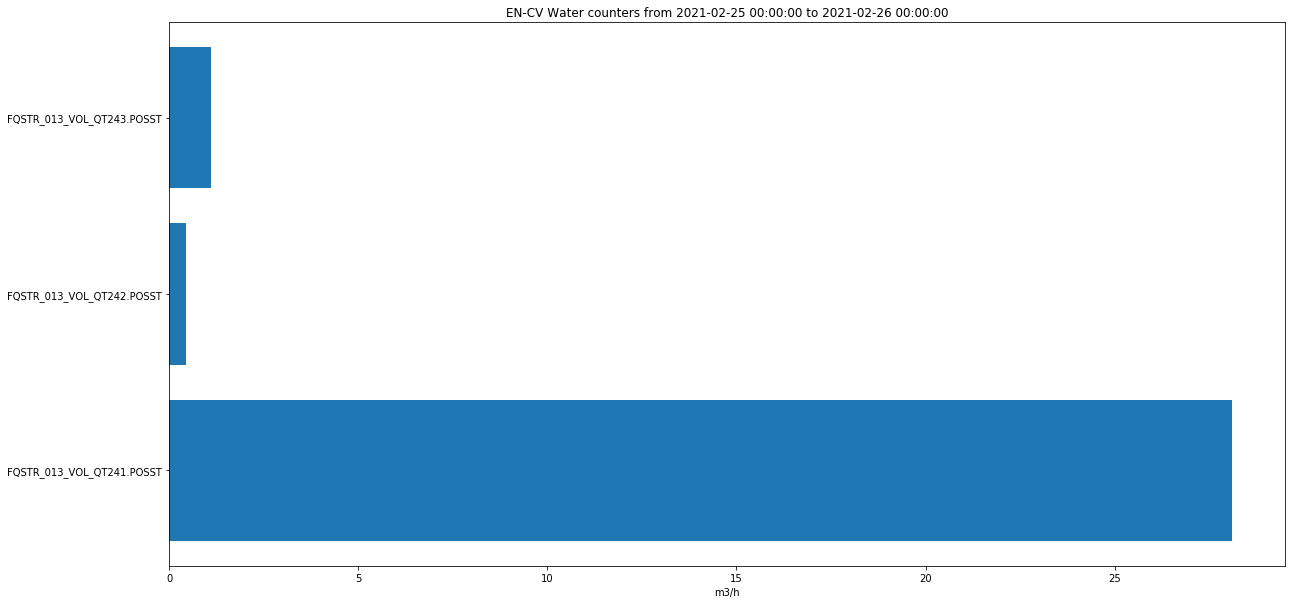

In [35]:
#(if numvars >= 2)
#PENDING to check num of vars, only makes sense for >= 2 variables 

fig2 = plt.figure(figsize=(20, 10))
#plt.plot([0,1], [0,1], 'k--', color='orange')
plt.barh(listCounters, totalList)

plt.xlabel("m3/h")
plt.title('EN-CV Water counters from '+ str(ModStartTime)+' to '+ str(ModEndTime))
#plt.xlabel('testxlabel')
figuresList.append(fig2)
